In [1]:
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import cmocean.cm as cm

%matplotlib inline

# Preliminaries

## Set Region

In [2]:
imin, imax = 160, 350
jmin, jmax = 120, 300

## Bathymetry and Mesh

In [7]:
bathy=nc.Dataset(
#    '../ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
nemolon=bathy.variables['nav_lon'][400:,:]
nemolat=bathy.variables['nav_lat'][400:,:]
bathy=bathy.variables['Bathymetry'][400:,:]
crop = nc.Dataset(
#        '../crop.nc')
    '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
tmask = crop.variables['tmask'][0,:,400:,:]
umask = crop.variables['umask'][0,:,400:,:]
vmask = crop.variables['vmask'][0,:,400:,:]
gdept = crop.variables['gdept'][0, :, 400:, :]
gdept0 = crop.variables['gdept_0'][0, :]
e2t = crop.variables['e2t'][0, 400:, :]
e1t = crop.variables['e1t'][0, 400:, :]
e3t = crop.variables['e3t'][0, :, 400:, :]

## Set Boundary Line(s)

In [9]:
pos = 1
if pos == 1:
    ddi = 100
    ddj = 120
    ddj2 = 150
elif pos == 2:
    ddi = 100
    ddj = 125
    ddj2 = 155
elif pos == 3:
    ddi = 100
    ddj = 115
    ddj2 = 145
elif pos == 4:
    ddi = 105
    ddj = 120
    ddj2 = 150
elif pos == 5:
    ddi = 95
    ddj = 120
    ddj2 = 150
line1_imin, line1_imax = imin, imin+ddi+1
line1_jmin, line1_jmax = jmin+ddj, jmin+ddj
line2_imin, line2_imax = imin+ddi, imin+ddi
line2_jmin, line2_jmax = jmin+ddj, jmin+ddj2+1
line3_imin, line3_imax = imin+ddi, imax
line3_jmin, line3_jmax = jmin+ddj2, jmin+ddj2

## Look at the position and Bathymetry along the boundary line(s)

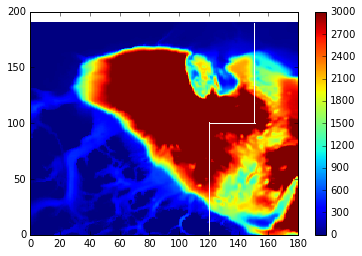

In [10]:
plt.pcolormesh(bathy[imin:imax, jmin:jmax], vmax=3000, vmin=0)
plt.colorbar()
plt.plot(np.array([line1_jmin, line1_jmax]) - jmin, np.array([line1_imin, line1_imax]) - imin, 'w')
plt.plot(np.array([line2_jmin, line2_jmax]) - jmin, np.array([line2_imin, line2_imax]) - imin, 'w')
plt.plot(np.array([line3_jmin, line3_jmax]) - jmin, np.array([line3_imin, line3_imax]) - imin, 'w');

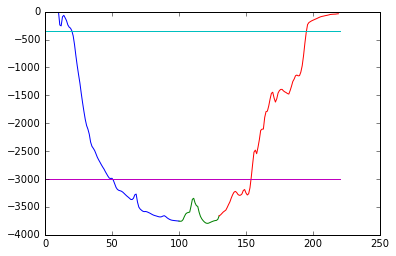

In [11]:
plt.plot(np.arange(ddi+1),-bathy[line1_imin:line1_imax, line1_jmin])
plt.plot(np.arange(30+1)+ddi, -bathy[line2_imin, line2_jmin:line2_jmax])
plt.plot(np.arange(90+100-ddi)+130-100+ddi,-bathy[line3_imin:line3_imax, line3_jmin])
plt.plot([0, 220], [-350, -350])
plt.plot([0, 220], [-3000, -3000]);

# Base Functions

In [16]:
def vel(keyword, T, ENG='EXH005'):
    """'design to obtain velocity field
    T: year, value: eg. 2002
    'ENG': string, can be ENG3,EXH001 or EXH005
    """
    addstr='/ocean/xiaoxiny/research/result_jasper/data_eng3/'
    # addstr = '../'
    if keyword =='U':
        nc_filename=sorted(glob.glob('%s/*%s*U*%s.nc'%(addstr,ENG,T)))
        uvel=nc.Dataset(nc_filename[0])
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    elif keyword =='V':
        nc_filename=sorted(glob.glob('%s/*%s*V*%s.nc'%(addstr,ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('%s/*%s*W*%s.nc'%(addstr,ENG,T)))
        wvel=nc.Dataset(nc_filename[0])
        data =wvel.variables['vovecrtz'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

## Look at Velocity along the Boundary for a Given Year

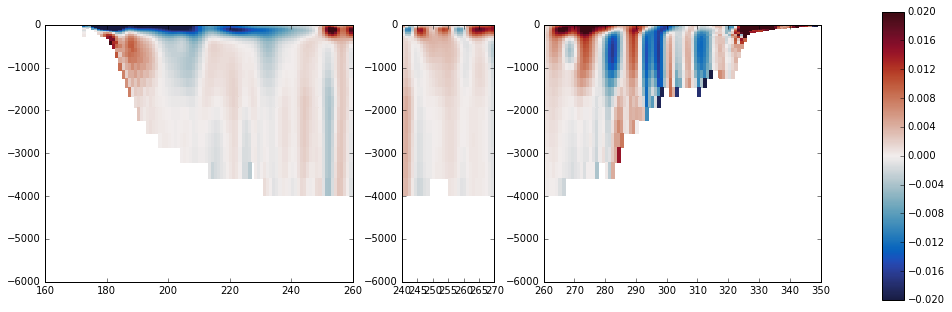

In [37]:
year = 2003
u_vel = vel('U', year)
v_vel = vel('V', year)

fig, axs = plt.subplots(1, 3, figsize=(15, 4.6),gridspec_kw = {'width_ratios':[100, 30, 90, 20]})
mesh = axs[0].pcolormesh(np.arange(line1_imin,line1_imax), -gdept0[:], 
                     u_vel[:, line1_imin:line1_imax, line1_jmin], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[1].pcolormesh(np.arange(line2_jmin,line2_jmax), -gdept0[:], 
                     -v_vel[:, line2_imin, line2_jmin:line2_jmax], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[2].pcolormesh(np.arange(line3_imin,line3_imax), -gdept0[:], 
                     u_vel[:, line3_imin:line3_imax, line3_jmin], cmap=cm.balance, vmax=0.02, vmin=-0.02)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.07, 0.02, 0.87])
fig.colorbar(mesh, cax=cbar_ax);

## Look at Total Volume Flux

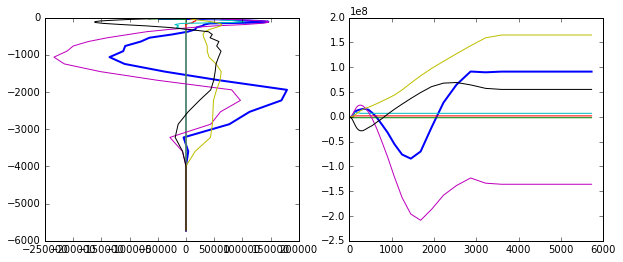

In [69]:
vfluxout_sec1 = np.zeros_like(gdept0)
vfluxout_sec2 = np.zeros_like(gdept0)
vfluxout_sec3 = np.zeros_like(gdept0)
vfluxout_ilow = np.zeros_like(gdept0)
vfluxout_jlow = np.zeros_like(gdept0)
vfluxout_ihi = np.zeros_like(gdept0)
vfluxout = np.zeros_like(gdept0)
for layer in range(50):
    vfluxout_sec1[layer] = np.sum(u_vel[layer, line1_imin:line1_imax, line1_jmin].filled()
         * e2t[line1_imin:line1_imax, line1_jmin] * e3t[layer, line1_imin:line1_imax, line1_jmin])
    vfluxout_sec2[layer] =  np.sum(-v_vel[layer, line2_imin, line2_jmin:line2_jmax].filled() 
          * e1t[line2_imin, line2_jmin:line2_jmax] * e3t[layer, line2_imin, line2_jmin:line2_jmax])
    vfluxout_sec3[layer] = np.sum(u_vel[layer, line3_imin:line3_imax, line3_jmin].filled() 
                        * e2t[line3_imin:line3_imax, line3_jmin]* e3t[layer,line3_imin:line3_imax, line3_jmin ])
    vfluxout_ilow[layer] = np.sum(-v_vel[layer, imin, jmin:line1_jmin+1].filled()
                          * e1t[imin, jmin:line1_jmin+1]* e3t[layer,imin, jmin:line1_jmin+1])
    vfluxout_jlow[layer] = np.sum(-u_vel[layer, imin:line2_imax+2, jmin].filled()
                          * e2t[imin:line2_imax+2, jmin] * e3t[layer,imin:line2_imax+2, jmin])
    vfluxout_ihi[layer] = np.sum(v_vel[layer, imax, jmin:line1_jmin+1].filled()
                          * e1t[imax, jmin:line1_jmin+1]* e3t[layer,imax, jmin:line1_jmin+1])
    vfluxout[layer] = (vfluxout_sec1[layer] + vfluxout_sec2[layer] + vfluxout_sec3[layer]
                       + vfluxout_ilow[layer] + vfluxout_jlow[layer] + vfluxout_ihi[layer])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(vfluxout, -gdept0, linewidth=2)
axs[0].plot(vfluxout_ihi, -gdept0)
axs[0].plot(vfluxout_jlow, -gdept0)
axs[0].plot(vfluxout_ilow, -gdept0)
axs[0].plot(vfluxout_sec3, -gdept0)
axs[0].plot(vfluxout_sec2, -gdept0)
axs[0].plot(vfluxout_sec1, -gdept0)

axs[1].plot(gdept0, np.cumsum(vfluxout*e3t[:, line1_imax, line1_jmin]), linewidth=2)
axs[1].plot(gdept0, np.cumsum(vfluxout_ihi*e3t[:, line1_imax, line1_jmin]))
axs[1].plot(gdept0, np.cumsum(vfluxout_jlow*e3t[:, line1_imax, line1_jmin]))
axs[1].plot(gdept0, np.cumsum(vfluxout_ilow*e3t[:, line1_imax, line1_jmin]))
axs[1].plot(gdept0, np.cumsum(vfluxout_sec3*e3t[:, line1_imax, line1_jmin]))
axs[1].plot(gdept0, np.cumsum(vfluxout_sec2*e3t[:, line1_imax, line1_jmin]))
axs[1].plot(gdept0, np.cumsum(vfluxout_sec1*e3t[:, line1_imax, line1_jmin]))
#axs[1].set_xlim((350, 650))

In [634]:
nt = 13
tracerfile = nc.Dataset('../EXH005-btscav_v2_19912016.nc')
tr8 = tracerfile.variables['TR_8'][nt, :]
tr10 = tracerfile.variables['TR_10'][nt, :]
tt = tr8+tr10

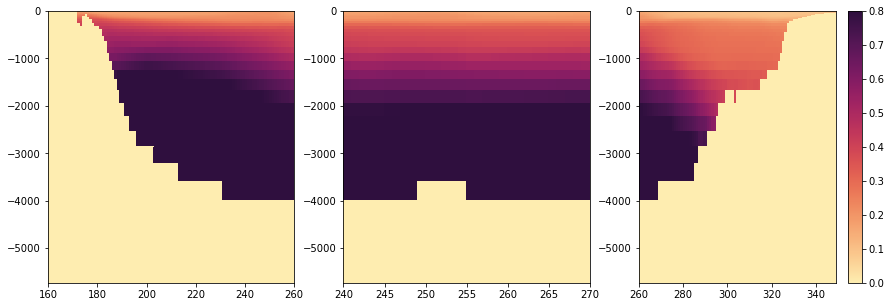

In [635]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh = axs[0].pcolormesh(np.arange(line1_imin,line1_imax), -gdept0[:], 
                     tt[:, line1_imin:line1_imax, line1_jmin], cmap=cm.matter, vmax=0.8, vmin=0)
axs[1].pcolormesh(np.arange(line2_jmin,line2_jmax), -gdept0[:], 
                     tt[:, line2_imin, line2_jmin:line2_jmax], cmap=cm.matter, vmax=0.8, vmin=0)
axs[2].pcolormesh(np.arange(line3_imin,line3_imax), -gdept0[:], 
                     tt[:, line3_imin:line3_imax, line3_jmin], cmap=cm.matter, vmax=0.8, vmin=0)

#axs[0].set_ylim(-4100, -500)
fig.colorbar(mesh, ax = axs[2])

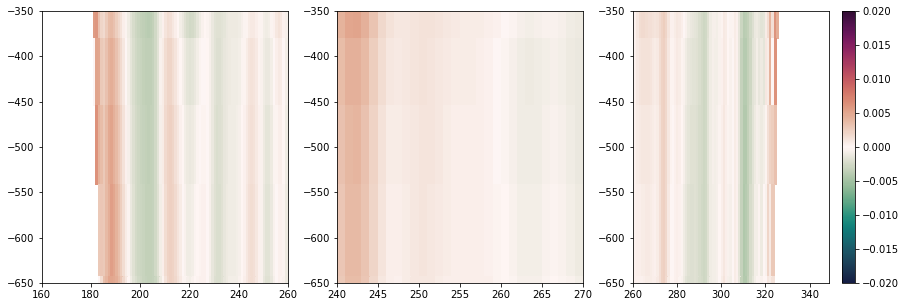

In [636]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh = axs[0].pcolormesh(np.arange(line1_imin,line1_imax), -gdept0[:], 
                     u_vel[:, line1_imin:line1_imax, line1_jmin] * tt[:, line1_imin:line1_imax, line1_jmin], cmap=cm.curl, vmax=0.02, vmin=-0.02)
axs[1].pcolormesh(np.arange(line2_jmin,line2_jmax), -gdept0[:], 
                     -v_vel[:, line2_imin, line2_jmin:line2_jmax] * tt[:, line2_imin, line2_jmin:line2_jmax], cmap=cm.curl, vmax=0.02, vmin=-0.02)
axs[2].pcolormesh(np.arange(line3_imin,line3_imax), -gdept0[:], 
                     u_vel[:, line3_imin:line3_imax, line3_jmin] * tt[:, line3_imin:line3_imax, line3_jmin], cmap=cm.curl, vmax=0.02, vmin=-0.02)
for ax in axs:
    ax.set_ylim(-650, -350)
fig.colorbar(mesh, ax = axs[2])

In [637]:
fluxout = np.zeros_like(gdept0)
fluxshallow = np.zeros_like(gdept0)
fluxdeep = np.zeros_like(gdept0)
for layer in range(50):
    fluxout[layer] = (np.sum(u_vel[layer, line1_imin:line1_imax, line1_jmin] * tt[layer, line1_imin:line1_imax, line1_jmin]
         * e2t[line1_imin:line1_imax, line1_jmin] * e3t[layer, line1_imin:line1_imax, line1_jmin])
     + np.sum(-v_vel[layer, line2_imin, line2_jmin:line2_jmax] * tt[layer, line2_imin, line2_jmin:line2_jmax]
          * e1t[line2_imin, line2_jmin:line2_jmax] * e3t[layer, line2_imin, line2_jmin:line2_jmax])
     + np.sum(u_vel[layer, line3_imin:line3_imax, line3_jmin] * tt[layer, line3_imin:line3_imax, line3_jmin]
                        * e2t[line3_imin:line3_imax, line3_jmin]* e3t[layer,line3_imin:line3_imax, line3_jmin ]))
    for i in np.arange(line1_imin,line1_imax):
        if u_vel[layer, i, line1_jmin] > -15:
            if bathy[i, line1_jmin] > 3000:
                fluxdeep[layer] = fluxdeep[layer] + (u_vel[layer, i, line1_jmin] * tt[layer, i, line1_jmin]
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
            else:
                fluxshallow[layer] = fluxshallow[layer] + (u_vel[layer, i, line1_jmin] * tt[layer, i, line1_jmin]
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
    for j in np.arange(line2_jmin,line2_jmax):
        if v_vel[layer, line2_imin, j] > -15:
            if bathy[line2_imin, j] > 3000:
                fluxdeep[layer] = fluxdeep[layer] + (-v_vel[layer, line2_imin, j] * tt[layer, line2_imin, j]
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
            else:
                fluxshallow[layer] = fluxshallow[layer] + (v_vel[layer, line2_imin, j] * tt[layer, line2_imin, j]
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
    for i in np.arange(line3_imin,line3_imax):
        if u_vel[layer, i, line3_jmin] > -15:
            if bathy[i, line3_jmin] > 3000:
                fluxdeep[layer] = fluxdeep[layer] + (u_vel[layer, i, line3_jmin] * tt[layer, i, line3_jmin]
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])
            else:
                fluxshallow[layer] = fluxshallow[layer] + (u_vel[layer, i, line3_jmin] * tt[layer, i, line3_jmin]
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])               
    print(layer, gdept0[layer], fluxout[layer], fluxshallow[layer], fluxdeep[layer], fluxshallow[layer]+fluxdeep[layer]-fluxout[layer])

0 0.494025373199 -1002.36056882 -1070.31165343 67.9510846017 -5.68434188608e-13
1 1.54137544346 -1152.90260579 -1197.82371855 44.9211127646 4.54747350886e-13
2 2.64566854846 -1247.87587811 -1290.91818854 43.0423104344 -9.09494701773e-13
3 3.81949484173 -1322.14744373 -1374.77148253 52.6240387996 1.36424205266e-12
4 5.07822352704 -1400.11296613 -1468.47139085 68.3584247187 -1.13686837722e-12
5 6.4406140032 -1495.59935254 -1582.98893178 87.3895792421 4.54747350886e-13
6 7.92956028693 -1619.18323511 -1715.57173625 96.3885011314 4.54747350886e-13
7 9.57299722866 -1736.27975852 -1836.6723869 100.392628382 -9.09494701773e-13
8 11.4050028658 -1888.8942319 -1974.07388741 85.1796555118 9.09494701773e-13
9 13.4671381447 -2127.35277769 -2172.77474435 45.4219666579 -2.27373675443e-12
10 15.8100733075 -2443.23347744 -2474.89219071 31.6587132716 0.0
11 18.4955595808 -2955.20632008 -2956.69452386 1.48820378421 3.18323145621e-12
12 21.5988154621 -3729.00160116 -3719.57330582 -9.42829533927 1.364242052

/Users/sallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Warning: converting a masked element to nan.


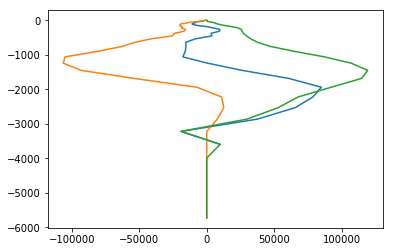

In [638]:
plt.plot(fluxout, -gdept0)
plt.plot(fluxshallow, -gdept0)
plt.plot(fluxdeep, -gdept0)

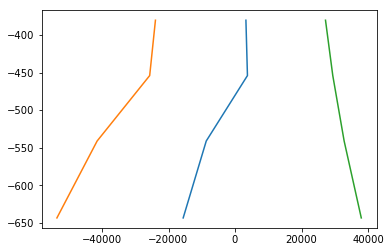

In [639]:
plt.plot(fluxout[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxshallow[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxdeep[rri:rrj], -gdept0[rri:rrj])

#fluxout1 = fluxout
#fluxout2 = fluxout
#fluxout3 = fluxout
#fluxout4 = fluxout
fluxout5 = fluxout

plt.plot(fluxout1, -gdept0)
plt.plot(fluxout2, -gdept0)
plt.plot(fluxout3, -gdept0)
plt.plot(fluxout4, -gdept0)
plt.plot(fluxout5, -gdept0)

rri, rrj = 29, 33
plt.plot(fluxout1[rri:rrj], -gdept0[rri:rrj], linewidth=2)
plt.plot(fluxout2[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxout3[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxout4[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxout5[rri:rrj], -gdept0[rri:rrj])

In [640]:
layer_volume = np.zeros_like(gdept0)
print (line1_imin, line1_imax, jmin, line1_jmax)
print (line3_imin, line3_imax, jmin, line3_jmax)
for layer in range(50):
    layer_volume[layer] = (np.sum(e1t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e2t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e3t[layer, line1_imin:line1_imax, jmin:line1_jmax] * 
                                 tmask[layer, line1_imin:line1_imax, jmin:line1_jmax]) +
                           np.sum(e1t[line3_imin:line3_imax, jmin:line3_jmax] * 
                                 e2t[line3_imin:line3_imax, jmin:line3_jmax] * 
                                 e3t[layer, line3_imin:line3_imax, jmin:line3_jmax] * 
                                 tmask[layer, line3_imin:line3_imax, jmin:line3_jmax]))

160 261 120 240
260 350 120 270


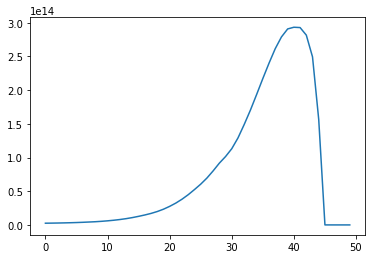

In [641]:
plt.plot(layer_volume)

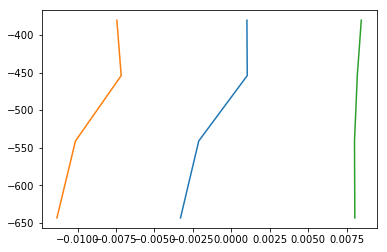

In [642]:
one_year = 365 * 86400
plt.plot(fluxout[rri:rrj]/layer_volume[rri:rrj]*one_year, -gdept0[rri:rrj])
plt.plot(fluxshallow[rri:rrj]/layer_volume[rri:rrj]*one_year, -gdept0[rri:rrj])
plt.plot(fluxdeep[rri:rrj]/layer_volume[rri:rrj]*one_year, -gdept0[rri:rrj])

## look at volume flux

In [643]:
vfluxout = np.zeros_like(gdept0)
vfluxshallow = np.zeros_like(gdept0)
vfluxdeep = np.zeros_like(gdept0)
for layer in range(50):
    vfluxout[layer] = (np.sum(u_vel[layer, line1_imin:line1_imax, line1_jmin] 
         * e2t[line1_imin:line1_imax, line1_jmin] * e3t[layer, line1_imin:line1_imax, line1_jmin])
     + np.sum(-v_vel[layer, line2_imin, line2_jmin:line2_jmax] 
          * e1t[line2_imin, line2_jmin:line2_jmax] * e3t[layer, line2_imin, line2_jmin:line2_jmax])
     + np.sum(u_vel[layer, line3_imin:line3_imax, line3_jmin] 
                        * e2t[line3_imin:line3_imax, line3_jmin]* e3t[layer,line3_imin:line3_imax, line3_jmin ]))
    for i in np.arange(line1_imin,line1_imax):
        if u_vel[layer, i, line1_jmin] > -15:
            if bathy[i, line1_jmin] > 3000:
                vfluxdeep[layer] = vfluxdeep[layer] + (u_vel[layer, i, line1_jmin]
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
            else:
                vfluxshallow[layer] = vfluxshallow[layer] + (u_vel[layer, i, line1_jmin] 
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
    for j in np.arange(line2_jmin,line2_jmax):
        if v_vel[layer, line2_imin, j] > -15:
            if bathy[line2_imin, j] > 3000:
                vfluxdeep[layer] = vfluxdeep[layer] + (-v_vel[layer, line2_imin, j] 
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
            else:
                vfluxshallow[layer] = vfluxshallow[layer] + (v_vel[layer, line2_imin, j] 
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
    for i in np.arange(line3_imin,line3_imax):
        if u_vel[layer, i, line3_jmin] > -15:
            if bathy[i, line3_jmin] > 3000:
                vfluxdeep[layer] = vfluxdeep[layer] + (u_vel[layer, i, line3_jmin] 
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])
            else:
                vfluxshallow[layer] = vfluxshallow[layer] + (u_vel[layer, i, line3_jmin] 
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])               
    print(layer, gdept0[layer], vfluxout[layer], vfluxshallow[layer], vfluxdeep[layer])

0 0.494025373199 -893.375449518 -2315.96215973 1422.58671021
1 1.54137544346 -1258.11621608 -2641.87360868 1383.7573926
2 2.64566854846 -1331.45804196 -2802.49012852 1471.03208656
3 3.81949484173 -1235.68650142 -2873.64959042 1637.963089
4 5.07822352704 -1066.86288461 -2929.17518726 1862.31230265
5 6.4406140032 -864.201719092 -3002.49668361 2138.29496451
6 7.92956028693 -673.251240691 -3060.90728402 2387.65604332
7 9.57299722866 -98.5643217296 -2732.93591977 2634.37159804
8 11.4050028658 561.696716255 -2234.34596432 2796.04268058
9 13.4671381447 889.297563485 -1969.83459435 2859.13215784
10 15.8100733075 721.534784325 -2343.58871275 3065.12349707
11 18.4955595808 -737.699868744 -3937.57495832 3199.87508958
12 21.5988154621 -3878.45611105 -7510.01119264 3631.55508159
13 25.2114088161 -3632.81207981 -9705.80921878 6072.99713897
14 29.4447289405 -4757.04139929 -13282.365908 8525.32450868
15 34.4341562372 -1240.78757445 -12622.0345668 11381.2469924
16 40.3440502005 821.948181741 -15744.758

/Users/sallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Warning: converting a masked element to nan.


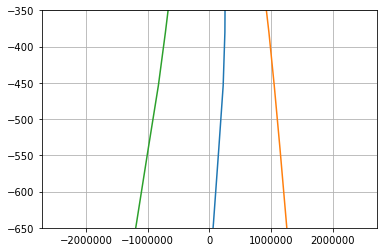

In [644]:
plt.plot(np.cumsum(vfluxout), -gdept0)
plt.plot(np.cumsum(vfluxdeep), -gdept0)
plt.plot(np.cumsum(vfluxshallow), -gdept0)
plt.ylim(-650, -350)
plt.grid()

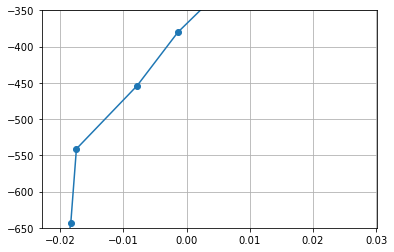

In [645]:
plt.plot(vfluxout/layer_volume*one_year, -gdept0, 'o-')
plt.ylim(-650, -350)
plt.grid()

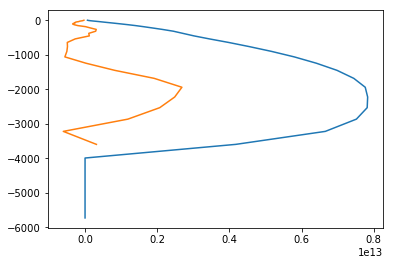

In [646]:
Q = 0.0267
radio_source = Q*layer_volume
plt.plot(radio_source, -gdept0)
plt.plot(fluxout*one_year, -gdept0)

In [647]:
nt = 13
tr8_2003 = tracerfile.variables['TR_8'][nt, :]
tr10_2003 = tracerfile.variables['TR_10'][nt, :]
tt_2003 = tr8_2003+tr10_2003
nt = 12
tr8_2002 = tracerfile.variables['TR_8'][nt, :]
tr10_2002 = tracerfile.variables['TR_10'][nt, :]
tt_2002 = tr8_2002+tr10_2002
nt = 14
tr8_2004 = tracerfile.variables['TR_8'][nt, :]
tr10_2004 = tracerfile.variables['TR_10'][nt, :]
tt_2004 = tr8_2004+tr10_2004

In [407]:
def tracer_volume(tt):
    tracer_layer_volume = np.zeros_like(gdept0)
    print (line1_imin, line1_imax, jmin, line1_jmax)
    print (line3_imin, line3_imax, jmin, line3_jmax)
    for layer in range(50):
        tracer_layer_volume[layer] = (np.sum(e1t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e2t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e3t[layer, line1_imin:line1_imax, jmin:line1_jmax] * 
                                 tt[layer, line1_imin:line1_imax, jmin:line1_jmax] *
                                 tmask[layer, line1_imin:line1_imax, jmin:line1_jmax]) +
                           np.sum(e1t[line3_imin:line3_imax, jmin:line3_jmax] * 
                                 e2t[line3_imin:line3_imax, jmin:line3_jmax] * 
                                 e3t[layer, line3_imin:line3_imax, jmin:line3_jmax] * 
                                 tt[layer, line3_imin:line3_imax, jmin:line3_jmax] *
                                 tmask[layer, line3_imin:line3_imax, jmin:line3_jmax]))
    return tracer_layer_volume

In [648]:
print(line1_imin)
t2002_volume = tracer_volume(tt_2002)
t2003_volume = tracer_volume(tt_2003)
t2004_volume = tracer_volume(tt_2004)

160
160 261 120 240
260 350 120 270
160 261 120 240
260 350 120 270
160 261 120 240
260 350 120 270


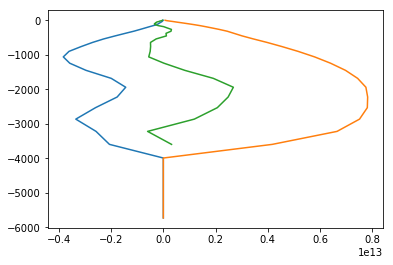

In [649]:
plt.plot((t2004_volume-t2002_volume)/2., -gdept0)
plt.plot(radio_source, -gdept0)
plt.plot(fluxout*one_year, -gdept0)
#plt.plot((t2003_volume), -gdept0)

In [413]:
print (nc.Dataset('../data_factor0.nc').variables['factor0'][:, 0, 0, 0].shape)
print (nc.Dataset('../data_factor.nc').variables['factor'][:, 0, 0, 0].shape)

(1,)
(1,)


In [415]:
nt = 12
with nc.Dataset('../data_factor0.nc') as fac0:
    fac0 = fac0.variables['factor0'][0,:,400:,:]
iceinput = tracerfile.variables['TR_12'][nt] 
Ice_from_predifinelastlayer=np.zeros_like(iceinput[nt,:,:])
for depth in range (len(fac0[:,0,0])):
    print (">>> reaching 50%") if (depth == len(fac0[:,0,0])/2) else None
    for i in range (len(fac0[0,:,0])):
        for j in range (len(fac0[0,0,:])):
            if fac0[depth,i,j]==1:
                Ice_from_predifinelastlayer[i,j]=iceinput[depth,i,j]
with nc.Dataset('../data_factor.nc') as data:
    fac = data.variables['factor'][0, :, 400:, :]

>>> reaching 50%


In [416]:
boundary_layer = np.zeros_like(fac0)
for i in range (len(fac0[0,:,0])):
    for j in range (len(fac0[0,0,:])):
        for depth in range (len(fac0[:,0,0])):
            if fac0[depth, i, j] == 1:
                boundary_layer[depth+1:, i, j] = tmask[depth+1:, i, j]

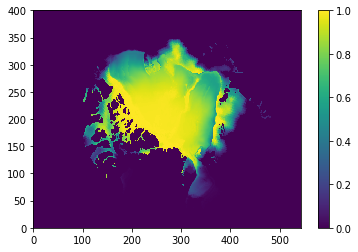

In [417]:
plt.pcolormesh(Ice_from_predifinelastlayer)
plt.colorbar()

In [611]:
def callsinking(layer, ice0, Ice_from_predifinelastlayer, fac):
    "s0 = normal sinking; also consider enhanced sinking if within the enhanced layer - delta_s = enhanced sinking"
    c0, c1 = -1387, 1874
    c0, c1 = -986.96, 1456.45
    s0 = (c0*np.array(ice0) + c1) * tmask[layer]
    s_from_predifinelastlayer = c0*np.array(Ice_from_predifinelastlayer) + c1
    se = np.zeros_like(s0)
    s  = np.zeros_like(s0)

    for i in range (len(ice0[:,0])):
        for j in range (len(ice0[0,:])):
            se[i, j] = min((3*(1-Ice_from_predifinelastlayer[i, j])+1)*s_from_predifinelastlayer[i, j], c1) 
    s = s0 + (se - s0) * fac
#    print (se[line1_imin+40, line1_jmin])
#    print (s[line1_imin+40, line1_jmin])
    return s 

In [555]:
ice_above_bl = Ice_from_predifinelastlayer[(line1_imin+40), line1_jmin]
enhancement =  3*(1-ice_above_bl)+1
print (ice_above_bl, enhancement)
c0, c1 = -986.96, 1456.45
s_above_bl = c0*ice_above_bl + c1
print (s_above_bl, s_above_bl*enhancement)
ice0 = TR_12_currentlayer[:, (line1_imin+40), line1_jmin]
s0 = (c0 * ice0[:] + c1) * tmask[:, (line1_imin+40), line1_jmin ]
print (s0)
se = min(s_above_bl*enhancement, c1) 
s = s0 + (se - s0) * fac[:, (line1_imin+40), line1_jmin]
print (s)

0.9893 1.03209888935
480.050106611 495.459181866
[ 472.79427624  472.79427624  472.79427624  472.79427624  472.79427624
  472.79427624  472.79427624  472.79427624  472.79427624  472.79427624
  472.79427624  472.79427624  472.79427624  472.79427624  472.79421741
  472.79145253  472.14399816  471.80038732  471.54295861  471.35088715
  470.81867566  470.40258946  470.25528565  470.32764335  470.55230519
  470.87456169  471.23405593  471.57972574  471.88415753  472.2104143
  472.76698033  473.80981365  475.4248611   477.33498678  478.97327105
  479.92480425  480.18264474  480.05010661  479.79638403  479.5848407
  479.49707022  479.5491913     0.            0.            0.            0.
    0.            0.            0.            0.        ]
[ 472.79427624  472.79427624  472.79427624  472.79427624  472.79427624
  472.79427624  472.79427624  472.79427624  472.79427624  472.79427624
  472.79427624  472.79427624  472.79427624  472.79427624  472.79421741
  472.79145253  472.14399816  471.800

In [559]:
def load_tracers(layer, nt):    
        TR_10_upperlayer = tracerfile.variables['TR_10'][nt, layer-1]
        TR_10_currentlayer = tracerfile.variables['TR_10'][nt, layer]
          
        TR_12_upperlayer = tracerfile.variables['TR_12'][nt, layer-1] 
        TR_12_currentlayer = tracerfile.variables['TR_12'][nt, layer]     
        
        return (TR_10_upperlayer, TR_10_currentlayer, 
               TR_12_upperlayer, TR_12_currentlayer)

In [650]:
nt = 13
deltasink = np.zeros((50, 400, 544))
sink_currentlayer = np.zeros_like(deltasink)
TR_12_currentlayer = np.zeros_like(deltasink)
for layer in range(50):
    TR_10_upperlayer, TR_10_currentlayer, TR_12_upperlayer, TR_12_currentlayer[layer] = load_tracers(layer, nt)
    sink_upperlayer = callsinking(layer, TR_12_upperlayer,
                                  Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer-1,...] )
    sink_currentlayer[layer] = callsinking(layer, TR_12_currentlayer[layer],
                                    Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer,...] )
     
    deltasink[layer] = (sink_upperlayer*TR_10_upperlayer - sink_currentlayer[layer]*TR_10_currentlayer)
#    trb(:,:,jk-1,jpmyt4)*s_th(:,:,jk-1)-trb(:,:,jk,jpmyt4)*s_th(:,:,jk))*rdz(:,:,jk+1)

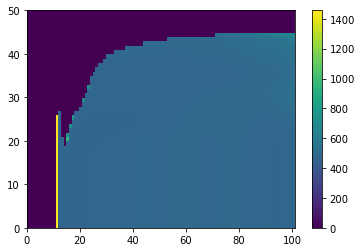

In [651]:
plt.pcolormesh(sink_currentlayer[:, line1_imin:line1_imax, line1_jmin] * tmask[:, line1_imin:line1_imax, line1_jmin])
plt.colorbar()

(25, 35)

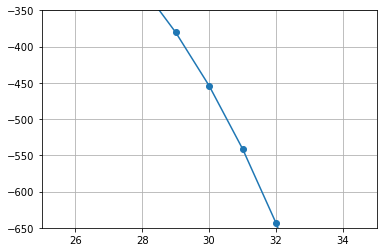

In [652]:
plt.plot(-gdept0, 'o-')
plt.grid()
plt.ylim(-650, -350)
plt.xlim(25, 35)

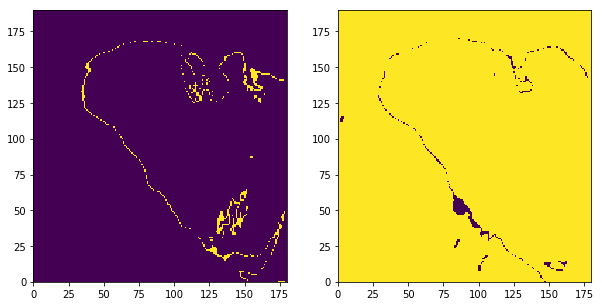

In [653]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
colour = axs[0].pcolormesh(fac0[29, imin:imax, jmin:jmax] )
layer = 31
axs[1].pcolormesh(tmask[layer, imin:imax, jmin:jmax] - tmask[layer-1, imin:imax, jmin:jmax])

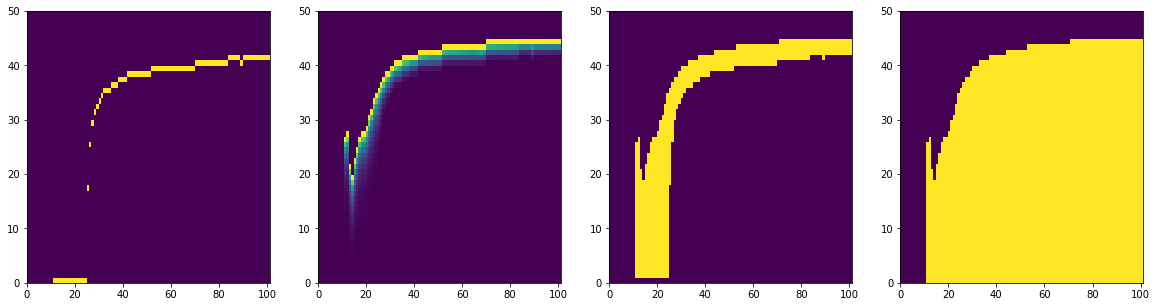

In [654]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].pcolormesh(fac0[:, line1_imin:line1_imax, line1_jmin])
axs[1].pcolormesh(fac[:, line1_imin:line1_imax, line1_jmin])
axs[2].pcolormesh(boundary_layer[:,line1_imin:line1_imax, line1_jmin])
axs[3].pcolormesh(tmask[:,line1_imin:line1_imax, line1_jmin])

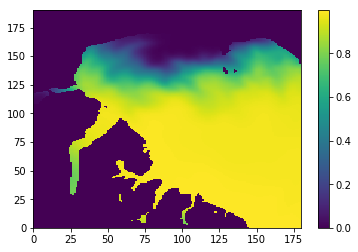

In [655]:
plt.pcolormesh(TR_12_currentlayer[29-1, imin:imax, jmin:jmax] * tmask[29-1, imin:imax, jmin:jmax])
plt.colorbar()

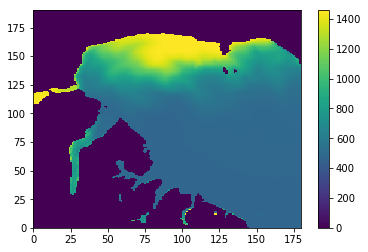

In [656]:
plt.pcolormesh(sink_currentlayer[29-1, imin:imax, jmin:jmax] * tmask[29-1, imin:imax, jmin:jmax])
plt.colorbar()

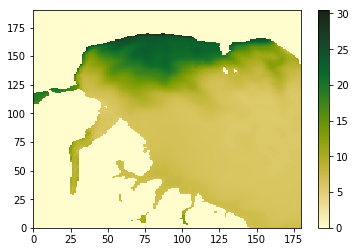

In [657]:
layer = 29-1
fluxinto = sink_currentlayer[layer, imin:imax, jmin:jmax] * tr10[layer, imin:imax, jmin:jmax] * tmask[layer, imin:imax, jmin:jmax]
plt.pcolormesh(fluxinto,
              cmap=cm.speed)
plt.colorbar()

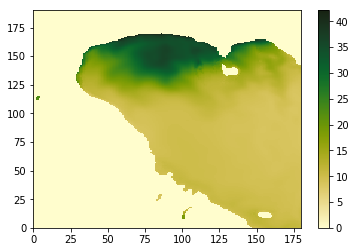

In [658]:
layer = 30
fluxinto = sink_currentlayer[layer, imin:imax, jmin:jmax] * tr10[layer, imin:imax, jmin:jmax] * tmask[layer, imin:imax, jmin:jmax]
plt.pcolormesh(fluxinto,
              cmap=cm.speed)
plt.colorbar()

453.937745167
-37647.3094584


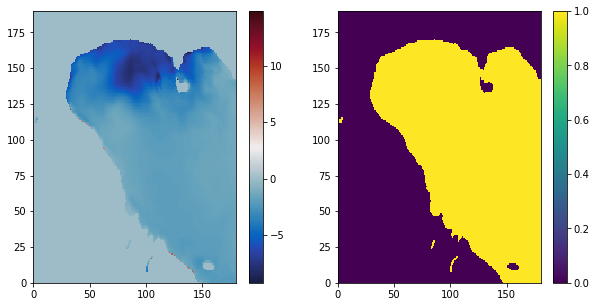

In [659]:
il = 30
fig, axs = plt.subplots(1, 2, figsize=(10,5))
colour = axs[0].pcolormesh(deltasink[il, imin:imax, jmin:jmax] * tmask[il, imin:imax, jmin:jmax], cmap=cm.balance)
fig.colorbar(colour, ax=axs[0])
colour = axs[1].pcolormesh(tmask[il, imin:imax, jmin:jmax])
fig.colorbar(colour, ax=axs[1])
print (gdept0[il])
print (np.sum(deltasink[il, imin:imax, jmin:jmax]))

In [660]:
layer_delta_sink = np.zeros_like(gdept0)
print (line1_imin, line1_imax, jmin, line1_jmax)
print (line3_imin, line3_imax, jmin, line3_jmax)
for layer in range(50):
    layer_delta_sink[layer] = (np.sum(e1t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e2t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 deltasink[layer, line1_imin:line1_imax, jmin:line1_jmax] * 
                                 tmask[layer, line1_imin:line1_imax, jmin:line1_jmax]) +
                           np.sum(e1t[line3_imin:line3_imax, jmin:line3_jmax] * 
                                 e2t[line3_imin:line3_imax, jmin:line3_jmax] * 
                                 deltasink[layer, line3_imin:line3_imax, jmin:line3_jmax] * 
                                 tmask[layer, line3_imin:line3_imax, jmin:line3_jmax]))

160 261 120 240
260 350 120 270


In [661]:
layer_delta_sink = np.zeros_like(gdept0)
print (line1_imin, line1_imax, jmin, line1_jmax)
print (line3_imin, line3_imax, jmin, line3_jmax)
for layer in range(50):
    for i in range(line1_imin, line1_imax):
        for j in range(jmin, line1_jmax):
            layer_delta_sink[layer] += (e1t[i,j] * 
                                 e2t[i,j] * 
                                 deltasink[layer, i, j] * 
                                 tmask[layer, i, j] )
    for i in range(line3_imin, line3_imax):
        for j in range(jmin, line3_jmax):
            layer_delta_sink[layer] += (e1t[i,j] * 
                                 e2t[i,j] * 
                                 deltasink[layer, i, j] * 
                                 tmask[layer, i, j] )

160 261 120 240
260 350 120 270


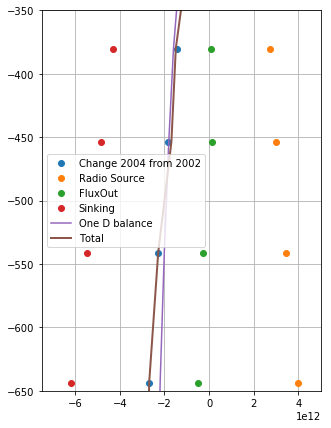

In [667]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7))
ax.plot((t2004_volume-t2002_volume)/2., -gdept0, 'o', label='Change 2004 from 2002')
ax.plot(radio_source, -gdept0, 'o', label='Radio Source')
ax.plot(fluxout*one_year, -gdept0, 'o', label='FluxOut')
ax.plot(layer_delta_sink, -gdept0, 'o', label='Sinking')
ax.plot(radio_source+layer_delta_sink, -gdept0, label='One D balance')
ax.plot(radio_source + layer_delta_sink + fluxout*one_year, -gdept0, label="Total", linewidth=2)
ax.set_ylim(-650, -350)
ax.set_xlim(-0.75e13, 0.5e13)
ax.legend()
ax.grid()

(-650, -350)

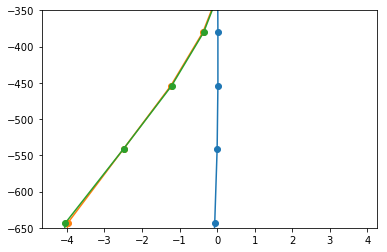

In [671]:
# Sinking = (sinking * concentration - sinking * concentration) * area
diff = ((tr10_2004[:, (line1_imin+40), line1_jmin]-tr10_2002[:, (line1_imin+40), line1_jmin])
        *e3t[:, (line1_imin+40), line1_jmin])
plt.plot(diff, -gdept0, 'o-')
#plt.plot(tr10_2003[:, (line1_imin+40), line1_jmin], -gdept0, 'o-')
diff = ((tr8_2004[:, (line1_imin+40), line1_jmin]-tr8_2002[:, (line1_imin+40), line1_jmin])
        *e3t[:, (line1_imin+40), line1_jmin])
plt.plot(diff, -gdept0, 'o-')
#plt.plot(tr8_2003[:, (line1_imin+40), line1_jmin], -gdept0, 'o-')
diff = ((tt_2004[:, (line1_imin+40), line1_jmin]-tt_2002[:, (line1_imin+40), line1_jmin])
       *e3t[:, (line1_imin+40), line1_jmin])
plt.plot(diff, -gdept0, 'o-')
#plt.plot(tt_2003[:, (line1_imin+40), line1_jmin], -gdept0, 'o-')
#plt.plot(TR_12_currentlayer[:, (line1_imin+40), line1_jmin], -gdept0, 'o-')
#plt.plot(sink_currentlayer[:, (line1_imin+40), line1_jmin], -gdept0, 'o-')
#plt.plot(deltasink[:, (line1_imin+40), line1_jmin]/10., -gdept0, 'o-')
#plt.plot(Q*e3t[:, (line1_imin+40), line1_jmin]/10., -gdept0, 'o-')
#plt.plot(Q*e3t[:, (line1_imin+40), line1_jmin]/10. + deltasink[:, (line1_imin+40), line1_jmin]/10., -gdept0, 'o-')
plt.ylim(-650, -350)
#plt.xlim(-1, 1.2)

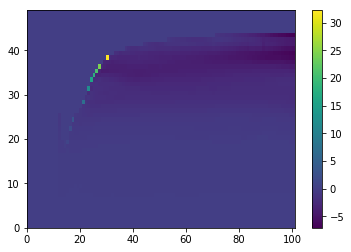

In [664]:
plt.pcolormesh(deltasink[1:, line1_imin:line1_imax, line1_jmin] * tmask[1:, line1_imin:line1_imax, line1_jmin])
plt.colorbar()

In [665]:
# ran for 14 years so 2015 is 25, 2002 is 12